
# DMV Zipcode Lifestyle Clustering

- Data: `DMV_Yelp_Dataset.csv` (housing + Yelp features). Source parts: `Yelp_Data.csv`, `DMV_House_Price_Data.csv`.
- How to run (macOS):
  1. `source .venv/bin/activate`
  2. Open in VS Code / Jupyter and run all cells (CPU only).
- Goal: Unsupervised clustering to describe zipcode lifestyle personas (price, commute accessibility, dining vitality).


In [134]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme()
pd.set_option("display.max_columns", None)
np.random.seed(42)


In [135]:

# Load data
DATA_PATH = "DMV_Yelp_Dataset.csv"
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()


Rows: 313, Columns: 25


,ZipCode,City,State,MedianPrice,Latitude,Longitude,NearestStation,MetroDistanceMeters,DistanceToDC_Meters,Growth_1Y,Growth_3Y,Growth_5Y,Growth_10Y,Price_Volatility,Yelp_Restaurant_Count,Yelp_Avg_Rating,Yelp_Avg_Review_Count,Num_Thai,Num_Coffee,Num_FastFood,Num_Japanese,Num_Italian,Num_American,Num_Bars,Num_HighEnd_Price4
0,20611,Bel Alton,MD,4.533226e+05,38.455014,-76.978244,Franconia-Springfield,38352.31,49481.13,0.051887,0.081930,0.316731,0.554269,0.021308,1,3.90,14.0,0,0,0,0,0,0,1,0
1,20689,Sunderland,MD,5.529582e+05,38.662952,-76.579405,Branch Ave,34137.83,46878.23,0.027186,0.068795,0.294265,0.489737,0.020455,0,0.00,0.0,0,0,0,0,0,0,0,0
2,20194,Reston,VA,7.756957e+05,38.981059,-77.340775,Reston Town Center,3565.41,28565.59,0.075680,0.184584,0.361115,0.457471,0.019603,19,3.38,144.1,3,11,5,1,5,6,5,0
3,22027,Dunn Loring,VA,1.320904e+06,38.894844,-77.223065,Dunn Loring-Merrifield,1410.10,16876.94,0.077052,0.170576,0.395729,0.585791,0.023984,25,3.23,97.5,4,9,5,3,3,4,4,0
4,22201,Arlington,VA,7.019834e+05,38.886566,-77.095250,Clarendon,149.83,5956.36,0.034824,0.040356,0.067716,0.214678,0.015575,293,3.85,888.1,31,124,61,22,60,92,66,0


In [136]:

# Basic quality checks
print("Duplicate ZipCodes:", df['ZipCode'].duplicated().sum())
non_numeric = ['ZipCode', 'City', 'State', 'NearestStation']
numeric_cols = [c for c in df.columns if c not in non_numeric]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

missing = df[numeric_cols].isna().sum()
print("Total missing numeric cells:", int(missing.sum()))
print("Any missing by column (non-zero only):")
print(missing[missing > 0])

summary = df[numeric_cols].describe().T[['min','max','mean','50%']]
summary.head(10)


Duplicate ZipCodes: 0
Total missing numeric cells: 22
Any missing by column (non-zero only):
Growth_1Y            1
Growth_3Y            1
Growth_5Y            9
Growth_10Y          10
Price_Volatility     1
dtype: int64


,min,max,mean,50%
MedianPrice,248130.711348,1.633353e+06,620989.826908,562687.243761
Latitude,37.927752,3.968864e+01,38.848783,38.879165
Longitude,-78.512907,-7.644288e+01,-77.308890,-77.215318
MetroDistanceMeters,130.850000,1.073530e+05,25843.741885,14355.600000
DistanceToDC_Meters,382.560000,1.340806e+05,45001.137636,37941.760000
Growth_1Y,-0.035992,1.068190e-01,0.050611,0.055138
Growth_3Y,-0.102209,2.515506e-01,0.114215,0.125941
Growth_5Y,-0.066611,6.936492e-01,0.353133,0.353680
Growth_10Y,-0.077546,1.153965e+00,0.601458,0.601543
Price_Volatility,0.010260,4.240148e-02,0.022095,0.021407


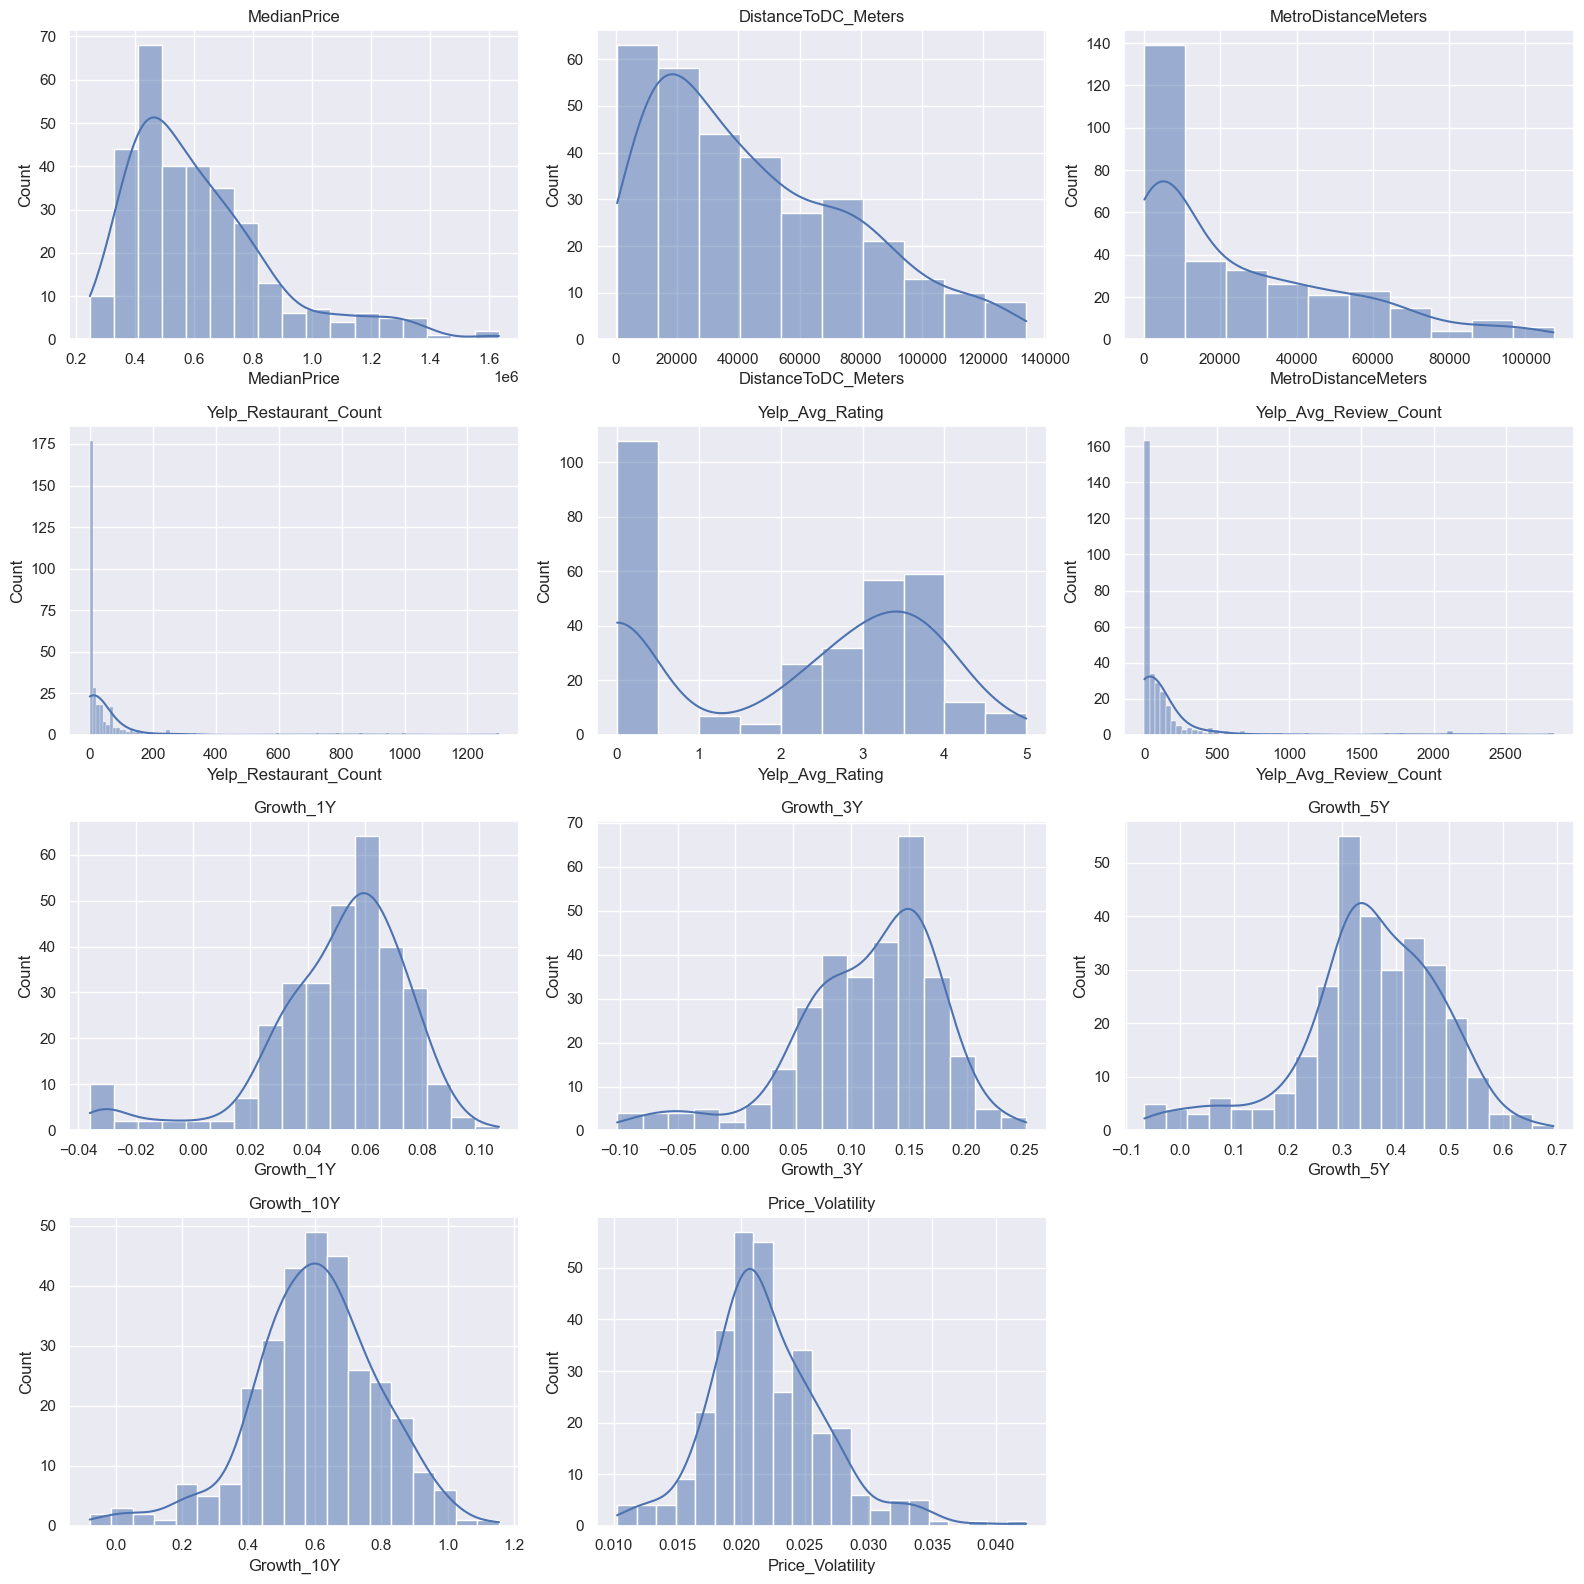

In [137]:

# Distributions for key signals
cols_main = [
    'MedianPrice','DistanceToDC_Meters','MetroDistanceMeters',
    'Yelp_Restaurant_Count','Yelp_Avg_Rating','Yelp_Avg_Review_Count',
    'Growth_1Y','Growth_3Y','Growth_5Y','Growth_10Y','Price_Volatility'
]
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
axes = axes.flatten()
for ax, col in zip(axes, cols_main):
    sns.histplot(data=df, x=col, kde=True, ax=ax, color="#4c72b0")
    ax.set_title(col)
for ax in axes[len(cols_main):]:
    ax.axis('off')
plt.tight_layout()


/var/folders/h7/q6mjq22j3zv1pnw4xpb_sj540000gn/T/ipykernel_89170/3172861373.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cuisine_totals.values, y=cuisine_totals.index, palette="crest")


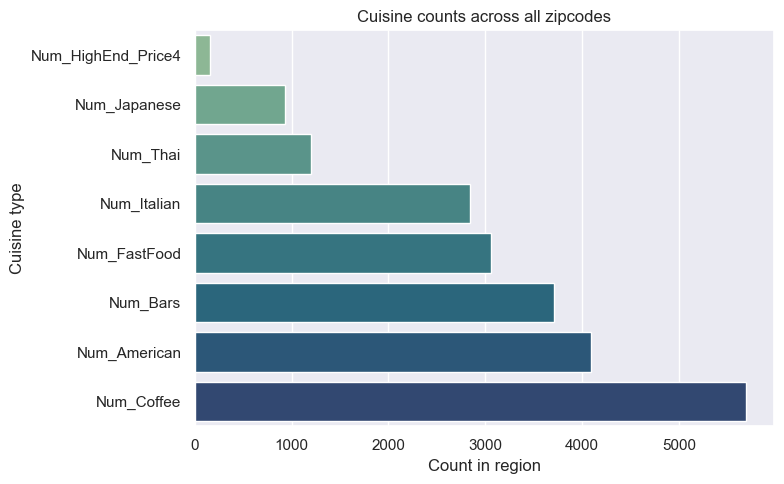

In [138]:

# Cuisine mix across the region
cuisine_cols = ['Num_Thai','Num_Coffee','Num_FastFood','Num_Japanese','Num_Italian','Num_American','Num_Bars','Num_HighEnd_Price4']
cuisine_totals = df[cuisine_cols].sum().sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=cuisine_totals.values, y=cuisine_totals.index, palette="crest")
plt.title('Cuisine counts across all zipcodes')
plt.xlabel('Count in region')
plt.ylabel('Cuisine type')
plt.tight_layout()


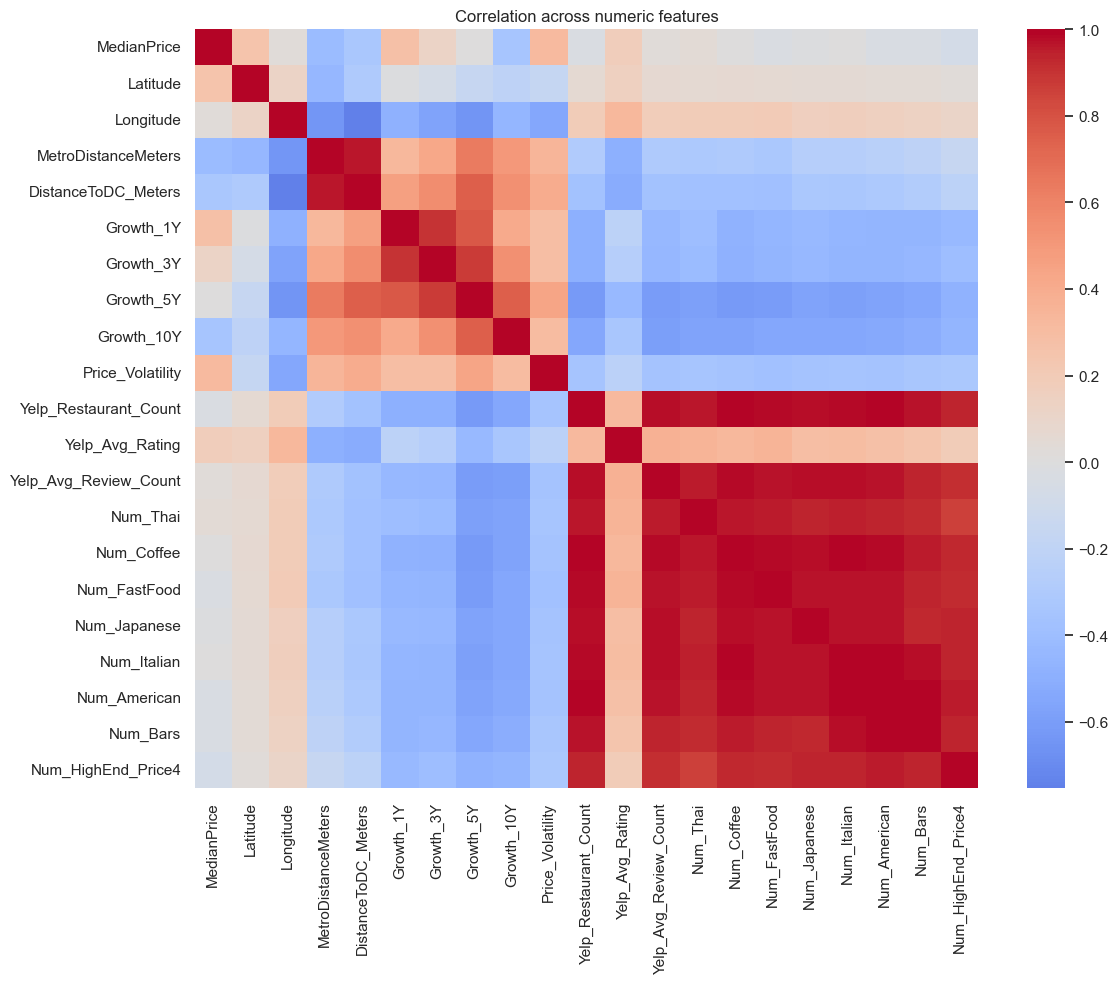

In [139]:

# Correlation heatmap (numeric features)
corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, square=False)
plt.title('Correlation across numeric features')
plt.tight_layout()


In [140]:

# Feature engineering: cuisine shares plus core signals
cuisine_cols = ['Num_Thai','Num_Coffee','Num_FastFood','Num_Japanese','Num_Italian','Num_American','Num_Bars','Num_HighEnd_Price4']
feat = df.copy()
feat['Yelp_Restaurant_Count_safe'] = feat['Yelp_Restaurant_Count'].replace(0, np.nan)
share_df = feat[cuisine_cols].div(feat['Yelp_Restaurant_Count_safe'], axis=0).fillna(0)
share_df.columns = [f"share_{c.replace('Num_','').lower()}" for c in cuisine_cols]
feat = pd.concat([feat, share_df], axis=1)
feature_cols = [
    'MedianPrice','DistanceToDC_Meters','MetroDistanceMeters',
    'Growth_1Y','Growth_3Y','Growth_5Y','Growth_10Y','Price_Volatility',
    'Yelp_Restaurant_Count','Yelp_Avg_Rating','Yelp_Avg_Review_Count'
] + list(share_df.columns)

X = feat[feature_cols]
X = X.fillna(X.median(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Feature matrix shape:', X.shape)
print('Any remaining NaN:', np.isnan(X_scaled).any())
X.head()


Feature matrix shape: (313, 19)
Any remaining NaN: False


,MedianPrice,DistanceToDC_Meters,MetroDistanceMeters,Growth_1Y,Growth_3Y,Growth_5Y,Growth_10Y,Price_Volatility,Yelp_Restaurant_Count,Yelp_Avg_Rating,Yelp_Avg_Review_Count,share_thai,share_coffee,share_fastfood,share_japanese,share_italian,share_american,share_bars,share_highend_price4
0,4.533226e+05,49481.13,38352.31,0.051887,0.081930,0.316731,0.554269,0.021308,1,3.90,14.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
1,5.529582e+05,46878.23,34137.83,0.027186,0.068795,0.294265,0.489737,0.020455,0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,7.756957e+05,28565.59,3565.41,0.075680,0.184584,0.361115,0.457471,0.019603,19,3.38,144.1,0.157895,0.578947,0.263158,0.052632,0.263158,0.315789,0.263158,0.0
3,1.320904e+06,16876.94,1410.10,0.077052,0.170576,0.395729,0.585791,0.023984,25,3.23,97.5,0.160000,0.360000,0.200000,0.120000,0.120000,0.160000,0.160000,0.0
4,7.019834e+05,5956.36,149.83,0.034824,0.040356,0.067716,0.214678,0.015575,293,3.85,888.1,0.105802,0.423208,0.208191,0.075085,0.204778,0.313993,0.225256,0.0


k=3: silhouette=0.257
k=4: silhouette=0.257
k=5: silhouette=0.233
k=6: silhouette=0.167
k=7: silhouette=0.191
Chosen k: 4


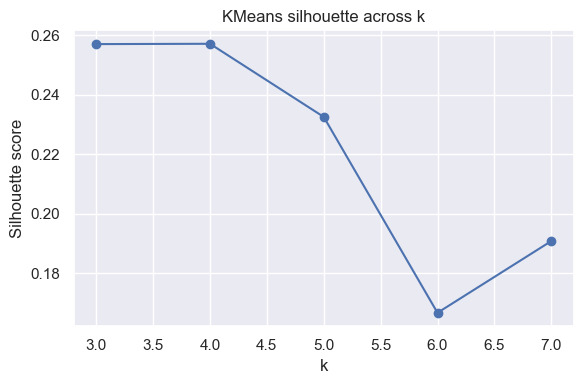

In [141]:

# K selection via silhouette
k_values = list(range(3, 8))
sil_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k={k}: silhouette={score:.3f}")

best_k = k_values[int(np.argmax(sil_scores))]
plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('KMeans silhouette across k')
plt.grid(True)
plt.tight_layout()
print('Chosen k:', best_k)


In [142]:

# Final clustering
model = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = model.fit_predict(X_scaled)
silhouette_final = silhouette_score(X_scaled, labels)
print(f"Final silhouette (k={best_k}): {silhouette_final:.3f}")

centers = pd.DataFrame(
    scaler.inverse_transform(model.cluster_centers_),
    columns=feature_cols
)
centers['cluster'] = range(best_k)

clusters = feat.copy()
clusters['cluster'] = labels
clusters['pca1'] = np.nan
clusters['pca2'] = np.nan
clusters.head()


Final silhouette (k=4): 0.257


,ZipCode,City,State,MedianPrice,Latitude,Longitude,NearestStation,MetroDistanceMeters,DistanceToDC_Meters,Growth_1Y,Growth_3Y,Growth_5Y,Growth_10Y,Price_Volatility,Yelp_Restaurant_Count,Yelp_Avg_Rating,Yelp_Avg_Review_Count,Num_Thai,Num_Coffee,Num_FastFood,Num_Japanese,Num_Italian,Num_American,Num_Bars,Num_HighEnd_Price4,Yelp_Restaurant_Count_safe,share_thai,share_coffee,share_fastfood,share_japanese,share_italian,share_american,share_bars,share_highend_price4,cluster,pca1,pca2
0,20611,Bel Alton,MD,4.533226e+05,38.455014,-76.978244,Franconia-Springfield,38352.31,49481.13,0.051887,0.081930,0.316731,0.554269,0.021308,1,3.90,14.0,0,0,0,0,0,0,1,0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0,NaN,NaN
1,20689,Sunderland,MD,5.529582e+05,38.662952,-76.579405,Branch Ave,34137.83,46878.23,0.027186,0.068795,0.294265,0.489737,0.020455,0,0.00,0.0,0,0,0,0,0,0,0,0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,NaN,NaN
2,20194,Reston,VA,7.756957e+05,38.981059,-77.340775,Reston Town Center,3565.41,28565.59,0.075680,0.184584,0.361115,0.457471,0.019603,19,3.38,144.1,3,11,5,1,5,6,5,0,19.0,0.157895,0.578947,0.263158,0.052632,0.263158,0.315789,0.263158,0.0,0,NaN,NaN
3,22027,Dunn Loring,VA,1.320904e+06,38.894844,-77.223065,Dunn Loring-Merrifield,1410.10,16876.94,0.077052,0.170576,0.395729,0.585791,0.023984,25,3.23,97.5,4,9,5,3,3,4,4,0,25.0,0.160000,0.360000,0.200000,0.120000,0.120000,0.160000,0.160000,0.0,0,NaN,NaN
4,22201,Arlington,VA,7.019834e+05,38.886566,-77.095250,Clarendon,149.83,5956.36,0.034824,0.040356,0.067716,0.214678,0.015575,293,3.85,888.1,31,124,61,22,60,92,66,0,293.0,0.105802,0.423208,0.208191,0.075085,0.204778,0.313993,0.225256,0.0,3,NaN,NaN


Explained variance ratio: [0.34509237 0.13927589]


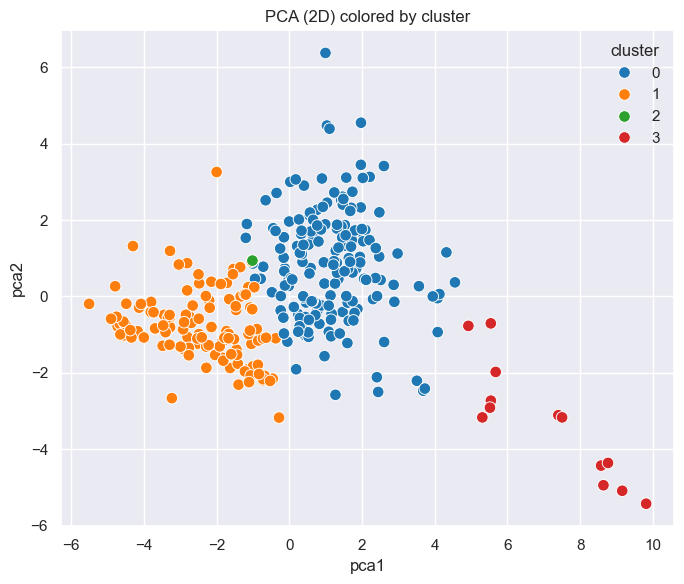

In [143]:

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)
clusters['pca1'] = pca_coords[:,0]
clusters['pca2'] = pca_coords[:,1]

plt.figure(figsize=(7, 6))
sns.scatterplot(data=clusters, x='pca1', y='pca2', hue='cluster', palette='tab10', s=70)
plt.title('PCA (2D) colored by cluster')
plt.tight_layout()

print('Explained variance ratio:', pca.explained_variance_ratio_)


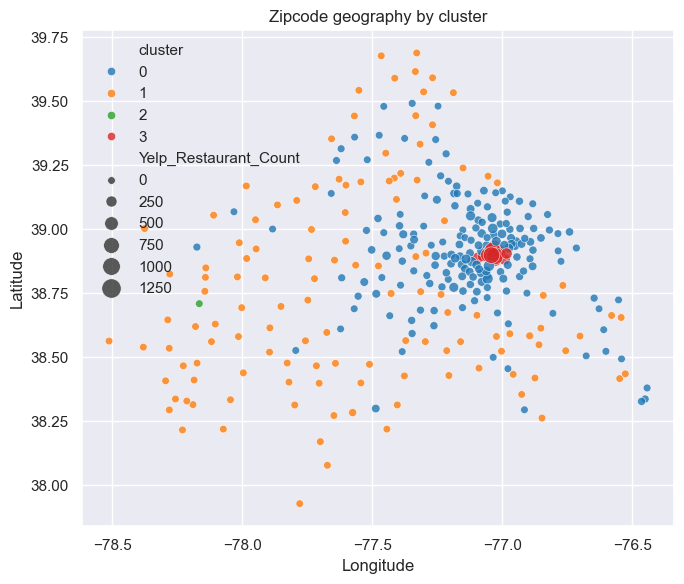

In [144]:

# Geography view
plt.figure(figsize=(7, 6))
sns.scatterplot(data=clusters, x='Longitude', y='Latitude', hue='cluster', size='Yelp_Restaurant_Count', palette='tab10', sizes=(30, 200), alpha=0.8)
plt.title('Zipcode geography by cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()


In [145]:

# Cluster profiles (numeric means and cuisine shares)
profile_cols = [
    'MedianPrice','DistanceToDC_Meters','MetroDistanceMeters',
    'Growth_1Y','Growth_5Y','Price_Volatility',
    'Yelp_Restaurant_Count','Yelp_Avg_Rating','Yelp_Avg_Review_Count'
]
summary_table = clusters.groupby('cluster')[profile_cols].mean().round(2)
summary_table


,MedianPrice,DistanceToDC_Meters,MetroDistanceMeters,Growth_1Y,Growth_5Y,Price_Volatility,Yelp_Restaurant_Count,Yelp_Avg_Rating,Yelp_Avg_Review_Count
cluster,,,,,,,,,
0,658852.16,28819.06,12433.14,0.05,0.32,0.02,40.98,3.10,124.97
1,572672.85,71829.69,47091.76,0.06,0.44,0.02,0.83,0.51,2.78
2,633303.97,100795.70,67024.74,0.07,0.47,0.03,3.00,4.47,313.30
3,571226.98,2641.75,529.82,-0.01,-0.00,0.01,602.31,3.90,1505.79


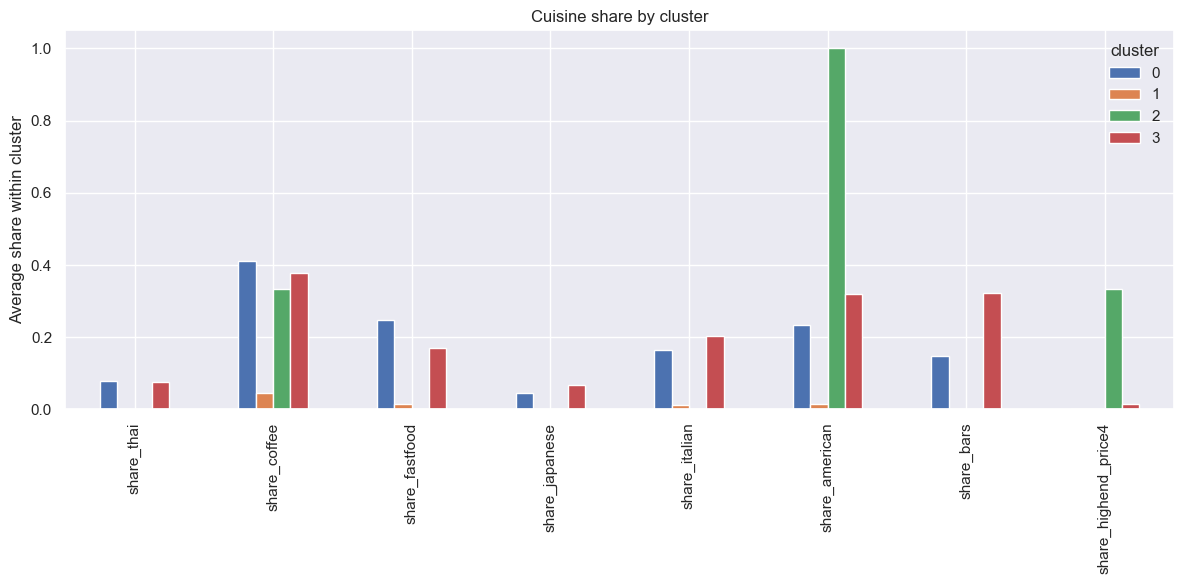

In [146]:

# Cuisine preferences by cluster (mean shares)
share_cols = [c for c in clusters.columns if c.startswith('share_')]
cluster_cuisine = clusters.groupby('cluster')[share_cols].mean().T
cluster_cuisine.plot(kind='bar', figsize=(12,6))
plt.ylabel('Average share within cluster')
plt.title('Cuisine share by cluster')
plt.tight_layout()



## Cluster narratives: price / commute / dining vitality
The next cells build summaries to label clusters as "high price / near DC / dining dense" vs "low price / far DC / sparse dining", and identify commuter-friendly urban rings vs exurban clusters.


In [147]:

# Key metrics table per cluster (median/mean for readability)
cluster_key = clusters.groupby('cluster').agg(
    n_zip=('ZipCode','count'),
    median_price=('MedianPrice','median'),
    dist_dc=('DistanceToDC_Meters','median'),
    metro_dist=('MetroDistanceMeters','median'),
    yelp_cnt=('Yelp_Restaurant_Count','median'),
    rating=('Yelp_Avg_Rating','mean'),
    review=('Yelp_Avg_Review_Count','mean')
).round(2)
cluster_key.sort_values('median_price', ascending=False)


,n_zip,median_price,dist_dc,metro_dist,yelp_cnt,rating,review
cluster,,,,,,,
2,1,633303.97,100795.70,67024.74,3.0,4.47,313.30
0,175,589885.27,22962.86,5090.43,24.0,3.10,124.97
3,13,585578.73,2452.58,453.79,596.0,3.90,1505.79
1,124,502767.37,71629.05,44870.64,0.0,0.51,2.78


In [148]:
# Convert distances from meters to miles and remove tiny clusters (n_zip==1)
METER_TO_MILE = 0.000621371
# add miles columns to clusters and cluster_key if not present
clusters['DistanceToDC_Miles'] = clusters['DistanceToDC_Meters'] * METER_TO_MILE
clusters['MetroDistance_Miles'] = clusters['MetroDistanceMeters'] * METER_TO_MILE
# recompute key metrics and convert to miles for readability
cluster_key = clusters.groupby('cluster').agg(
    n_zip=('ZipCode','count'),
    median_price=('MedianPrice','median'),
    dist_dc_m=('DistanceToDC_Meters','median'),
    metro_dist_m=('MetroDistanceMeters','median'),
    yelp_cnt=('Yelp_Restaurant_Count','median'),
    rating=('Yelp_Avg_Rating','mean'),
    review=('Yelp_Avg_Review_Count','mean')
).round(2)
cluster_key['dist_dc_miles'] = (cluster_key['dist_dc_m'] * METER_TO_MILE).round(2)
cluster_key['metro_dist_miles'] = (cluster_key['metro_dist_m'] * METER_TO_MILE).round(2)
# identify small clusters to drop (single-zipcode clusters)
small = cluster_key[cluster_key['n_zip'] <= 1].index.tolist()
if len(small) > 0:
    print('Removing clusters with <=1 zipcode:', small)
    # filter out those zipcodes from further analysis
    clusters = clusters[~clusters['cluster'].isin(small)].reset_index(drop=True)
    # recompute cluster_key after removal
    cluster_key = clusters.groupby('cluster').agg(
        n_zip=('ZipCode','count'),
        median_price=('MedianPrice','median'),
        dist_dc_m=('DistanceToDC_Meters','median'),
        metro_dist_m=('MetroDistanceMeters','median'),
        yelp_cnt=('Yelp_Restaurant_Count','median'),
        rating=('Yelp_Avg_Rating','mean'),
        review=('Yelp_Avg_Review_Count','mean')
    ).round(2)
    cluster_key['dist_dc_miles'] = (cluster_key['dist_dc_m'] * METER_TO_MILE).round(2)
    cluster_key['metro_dist_miles'] = (cluster_key['metro_dist_m'] * METER_TO_MILE).round(2)
else:
    print('No small clusters to remove')
# show updated cluster_key sorted by price
cluster_key = cluster_key.sort_values('median_price', ascending=False)
cluster_key

Removing clusters with <=1 zipcode: [2]


,n_zip,median_price,dist_dc_m,metro_dist_m,yelp_cnt,rating,review,dist_dc_miles,metro_dist_miles
cluster,,,,,,,,,
0,175,589885.27,22962.86,5090.43,24.0,3.10,124.97,14.27,3.16
3,13,585578.73,2452.58,453.79,596.0,3.90,1505.79,1.52,0.28
1,124,502767.37,71629.05,44870.64,0.0,0.51,2.78,44.51,27.88


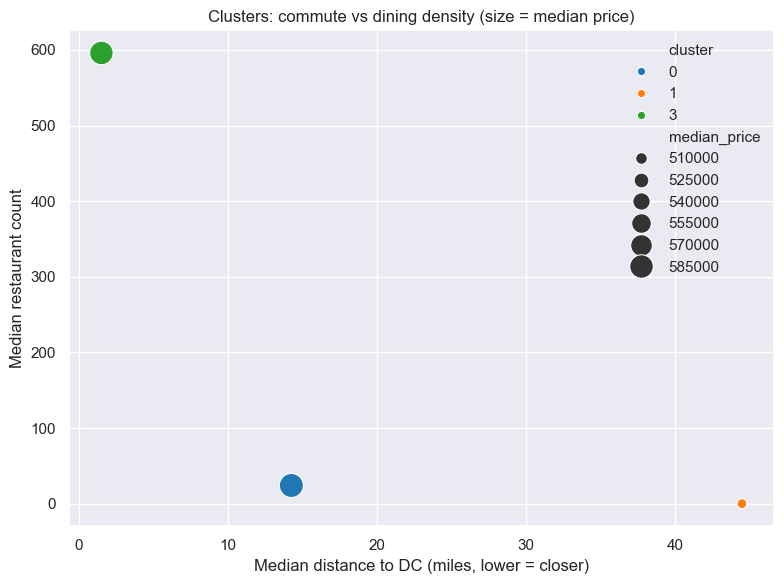

In [149]:
# Plot: commute vs dining density (bubble size = price) using miles
plt.figure(figsize=(8,6))
plot_df = cluster_key.reset_index()
sns.scatterplot(data=plot_df, x='dist_dc_miles', y='yelp_cnt', size='median_price', hue='cluster', palette='tab10', sizes=(50, 300), legend='brief')
plt.xlabel('Median distance to DC (miles, lower = closer)')
plt.ylabel('Median restaurant count')
plt.title('Clusters: commute vs dining density (size = median price)')
plt.tight_layout()


In [150]:
# Auto-generate narratives using quantile buckets
# Note: cluster_key columns were renamed to miles in previous cell (dist_dc -> dist_dc_miles, metro_dist -> metro_dist_miles)
q_price = cluster_key['median_price'].quantile([0.33, 0.66])
q_dc = cluster_key['dist_dc_miles'].quantile([0.33, 0.66])
q_metro = cluster_key['metro_dist_miles'].quantile([0.33, 0.66])
q_food = cluster_key['yelp_cnt'].quantile([0.33, 0.66])

def bucket_high(val, q):
    if val <= q.iloc[0]:
        return 'low'
    elif val <= q.iloc[1]:
        return 'mid'
    return 'high'

def bucket_low_better(val, q):
    # For distances: lower is better/closer
    if val <= q.iloc[0]:
        return 'near'
    elif val <= q.iloc[1]:
        return 'mid'
    return 'far'

narratives = []
for cid, row in cluster_key.iterrows():
    price_tag = bucket_high(row['median_price'], q_price)
    food_tag = bucket_high(row['yelp_cnt'], q_food)
    dc_tag = bucket_low_better(row['dist_dc_miles'], q_dc)
    metro_tag = bucket_low_better(row['metro_dist_miles'], q_metro)
    text = (
        f"Cluster {cid}: price {price_tag} / DC {dc_tag} / Metro {metro_tag} / dining density {food_tag}; "
        f"avg rating {row['rating']:.2f}, avg reviews {row['review']:.0f}"
    )
    narratives.append(text)
narratives

['Cluster 0: price high / DC mid / Metro mid / dining density mid; avg rating 3.10, avg reviews 125',
 'Cluster 3: price mid / DC near / Metro near / dining density high; avg rating 3.90, avg reviews 1506',
 'Cluster 1: price low / DC far / Metro far / dining density low; avg rating 0.51, avg reviews 3']


> Tip: narratives use quantile buckets; adjust to fixed thresholds if desired (e.g., price > $800k = high).


In [151]:

# Save outputs for reporting
clusters.to_csv('clustered_zipcodes.csv', index=False)
centers.to_csv('cluster_centers_unscaled.csv', index=False)
print('Saved clustered_zipcodes.csv and cluster_centers_unscaled.csv')


Saved clustered_zipcodes.csv and cluster_centers_unscaled.csv


In [152]:
# Data cleaning and past price backcast
# Treat Yelp_Avg_Rating == 0 as missing (likely no restaurants / no rating).
df_clean = df.copy()
# flag zero ratings as missing
df_clean['yelp_rating_missing'] = df_clean['Yelp_Avg_Rating'] == 0
df_clean.loc[df_clean['Yelp_Avg_Rating'] == 0, 'Yelp_Avg_Rating'] = np.nan
# Fill rating missing with median (safe), keep a flag for analysis
df_clean['Yelp_Avg_Rating'] = df_clean['Yelp_Avg_Rating'].fillna(df_clean['Yelp_Avg_Rating'].median())
# Recompute cuisine shares in case of any changes
cuisine_cols = ['Num_Thai','Num_Coffee','Num_FastFood','Num_Japanese','Num_Italian','Num_American','Num_Bars','Num_HighEnd_Price4']
df_clean['Yelp_Restaurant_Count_safe'] = df_clean['Yelp_Restaurant_Count'].replace(0, np.nan)
share_df = df_clean[cuisine_cols].div(df_clean['Yelp_Restaurant_Count_safe'], axis=0).fillna(0)
share_df.columns = [f"share_{c.replace('Num_','').lower()}" for c in cuisine_cols]
df_clean = pd.concat([df_clean, share_df], axis=1)
# Compute past prices using (current_price / (1 + cumulative_growth)) assumption
# If Growth_X is total cumulative growth over the period (e.g., 5Y total), price X years ago ~= MedianPrice / (1 + Growth_X)
for years in [('1Y','Growth_1Y'), ('3Y','Growth_3Y'), ('5Y','Growth_5Y'), ('10Y','Growth_10Y')]:
    label, growth_col = years
    out_col = f'Price_back_{label}'
    df_clean[out_col] = df_clean['MedianPrice'] / (1 + df_clean[growth_col].replace({np.nan:0}))
# Save cleaned dataset
clean_path = 'DMV_Yelp_Dataset_clean.csv'
df_clean.to_csv(clean_path, index=False)
print(f'Saved cleaned dataset to {clean_path} (n_rows={df_clean.shape[0]})')
df_clean.head()


Saved cleaned dataset to DMV_Yelp_Dataset_clean.csv (n_rows=313)


,ZipCode,City,State,MedianPrice,Latitude,Longitude,NearestStation,MetroDistanceMeters,DistanceToDC_Meters,Growth_1Y,Growth_3Y,Growth_5Y,Growth_10Y,Price_Volatility,Yelp_Restaurant_Count,Yelp_Avg_Rating,Yelp_Avg_Review_Count,Num_Thai,Num_Coffee,Num_FastFood,Num_Japanese,Num_Italian,Num_American,Num_Bars,Num_HighEnd_Price4,yelp_rating_missing,Yelp_Restaurant_Count_safe,share_thai,share_coffee,share_fastfood,share_japanese,share_italian,share_american,share_bars,share_highend_price4,Price_back_1Y,Price_back_3Y,Price_back_5Y,Price_back_10Y
0,20611,Bel Alton,MD,4.533226e+05,38.455014,-76.978244,Franconia-Springfield,38352.31,49481.13,0.051887,0.081930,0.316731,0.554269,0.021308,1,3.90,14.0,0,0,0,0,0,0,1,0,False,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,4.309615e+05,4.189946e+05,344278.943943,291662.876040
1,20689,Sunderland,MD,5.529582e+05,38.662952,-76.579405,Branch Ave,34137.83,46878.23,0.027186,0.068795,0.294265,0.489737,0.020455,0,3.32,0.0,0,0,0,0,0,0,0,0,True,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.383236e+05,5.173661e+05,427237.101981,371178.368137
2,20194,Reston,VA,7.756957e+05,38.981059,-77.340775,Reston Town Center,3565.41,28565.59,0.075680,0.184584,0.361115,0.457471,0.019603,19,3.38,144.1,3,11,5,1,5,6,5,0,False,19.0,0.157895,0.578947,0.263158,0.052632,0.263158,0.315789,0.263158,0.0,7.211214e+05,6.548251e+05,569897.440723,532220.159508
3,22027,Dunn Loring,VA,1.320904e+06,38.894844,-77.223065,Dunn Loring-Merrifield,1410.10,16876.94,0.077052,0.170576,0.395729,0.585791,0.023984,25,3.23,97.5,4,9,5,3,3,4,4,0,False,25.0,0.160000,0.360000,0.200000,0.120000,0.120000,0.160000,0.160000,0.0,1.226408e+06,1.128422e+06,946390.690410,832962.623591
4,22201,Arlington,VA,7.019834e+05,38.886566,-77.095250,Clarendon,149.83,5956.36,0.034824,0.040356,0.067716,0.214678,0.015575,293,3.85,888.1,31,124,61,22,60,92,66,0,False,293.0,0.105802,0.423208,0.208191,0.075085,0.204778,0.313993,0.225256,0.0,6.783603e+05,6.747531e+05,657462.806209,577917.477373


Clustering scores (None means not-applicable):
{'kmeans': {'silhouette': 0.25719925636318075, 'calinski_harabasz': 69.41605523507387}, 'gmm': {'silhouette': 0.19517694243739261, 'calinski_harabasz': 65.69073461247946}, 'hdbscan': {'silhouette': 0.4114781219375285, 'calinski_harabasz': 119.48710168635152}}


/Users/wilson/VT/2025 Fall/Urben/Final/.venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


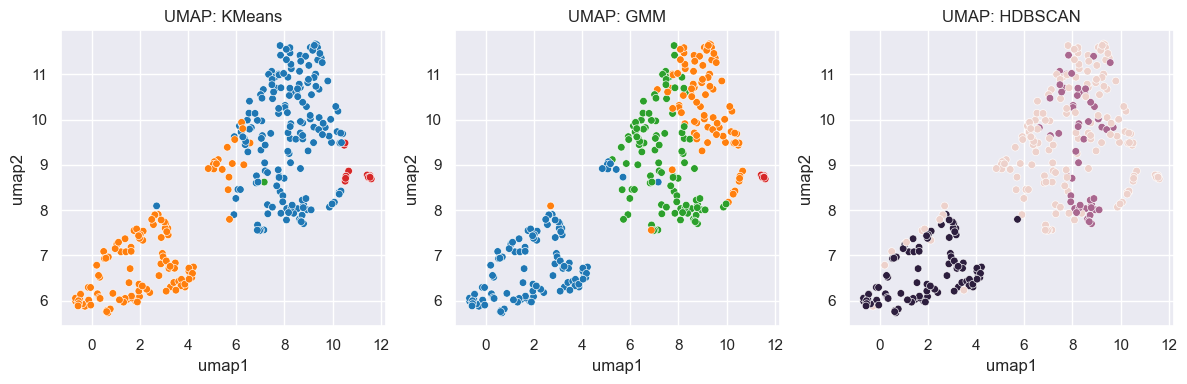

In [153]:
# Alternative clustering methods: GaussianMixture and HDBSCAN (if available), and UMAP for visualization
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score
# try import hdbscan and umap, install if missing (in-notebook install)
def try_import(pkg, pip_name=None):
    try:
        module = __import__(pkg)
        return module
    except Exception:
        import sys, subprocess
        name = pip_name or pkg
        print(f'Installing {name}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', name])
        return __import__(pkg)
# HDBSCAN (optional)
hdbscan = None
umap = None
try:
    import hdbscan as _hdb
    hdbscan = _hdb
except Exception:
    try:
        hdbscan = try_import('hdbscan')
    except Exception as e:
        print('hdbscan not available (skipping HDBSCAN).')
# UMAP (for visualization)
try:
    import umap.umap_ as _um
    umap = _um
except Exception:
    try:
        umap = try_import('umap.umap_', 'umap-learn')
    except Exception:
        print('umap not available; PCA fallback will be used for viz.')
# Gaussian Mixture clustering (use same k as KMeans for comparison)
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
# HDBSCAN if available (no need to pre-specify k)
if hdbscan is not None:
    try:
        hdb = hdbscan.HDBSCAN(min_cluster_size=8, metric='euclidean')
        hdb_labels = hdb.fit_predict(X_scaled)
    except Exception as e:
        print('HDBSCAN failed:', e)
        hdb_labels = None
else:
    hdb_labels = None
# Evaluate clusterings: silhouette (when valid) and calinski-harabasz
def safe_scores(X, labels):
    import numpy as _np
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    if labels is None:
        return {'silhouette': None, 'calinski_harabasz': None}
    # consider only non-noise labels (hdbscan uses -1 as noise)
    mask = labels >= 0
    uniq = _np.unique(labels[mask])
    if len(uniq) < 2:
        return {'silhouette': None, 'calinski_harabasz': None}
    try:
        sil = silhouette_score(X[mask], labels[mask])
    except Exception:
        sil = None
    try:
        ch = calinski_harabasz_score(X[mask], labels[mask])
    except Exception:
        ch = None
    return {'silhouette': sil, 'calinski_harabasz': ch}
scores = {}
scores['kmeans'] = safe_scores(X_scaled, labels)
scores['gmm'] = safe_scores(X_scaled, gmm_labels)
scores['hdbscan'] = safe_scores(X_scaled, hdb_labels)
print('Clustering scores (None means not-applicable):')
print(scores)
# UMAP visualization (if available)
if umap is not None:
    reducer = umap.UMAP(n_components=2, random_state=42)
    emb = reducer.fit_transform(X_scaled)
    viz_df = pd.DataFrame(emb, columns=['umap1','umap2'])
    viz_df['kmeans'] = labels
    viz_df['gmm'] = gmm_labels
    if hdb_labels is not None:
        viz_df['hdbscan'] = hdb_labels
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    sns.scatterplot(data=viz_df, x='umap1', y='umap2', hue='kmeans', palette='tab10', s=30, legend=None)
    plt.title('UMAP: KMeans')
    plt.subplot(1,3,2)
    sns.scatterplot(data=viz_df, x='umap1', y='umap2', hue='gmm', palette='tab10', s=30, legend=None)
    plt.title('UMAP: GMM')
    if 'hdbscan' in viz_df.columns:
        plt.subplot(1,3,3)
        sns.scatterplot(data=viz_df, x='umap1', y='umap2', hue='hdbscan', s=30, legend=None)
        plt.title('UMAP: HDBSCAN')
    plt.tight_layout()
else:
    print('UMAP not available; skipping UMAP viz (PCA already used earlier).')


Fitting GMM with k=4 on 312 zipcodes...

--- Part 1: Price vs Dining Density ---
Cluster Summary (Sorted by Price):
             MedianPrice  Yelp_Restaurant_Count  DistanceToDC_Miles  \
gmm_cluster                                                           
0              705415.82                   36.0               11.90   
3              577850.71                  658.5                1.50   
1              505536.39                    0.0               44.32   
2              454225.32                    8.0               23.82   

             Yelp_Avg_Rating  ZipCode  
gmm_cluster                            
0                       3.31      105  
3                       3.90       12  
1                       0.36      115  
2                       2.75       80  

Assigned Cluster Names:
0    Affluent Suburbs (Quiet Wealth)
3          Urban Core (High Density)
1            Exurbs (Affordable/Far)
2            Exurbs (Affordable/Far)
dtype: object


/var/folders/h7/q6mjq22j3zv1pnw4xpb_sj540000gn/T/ipykernel_89170/205316271.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x='Cluster_Name', y='MedianPrice', palette='tab10', showfliers=False, ax=axes[1])


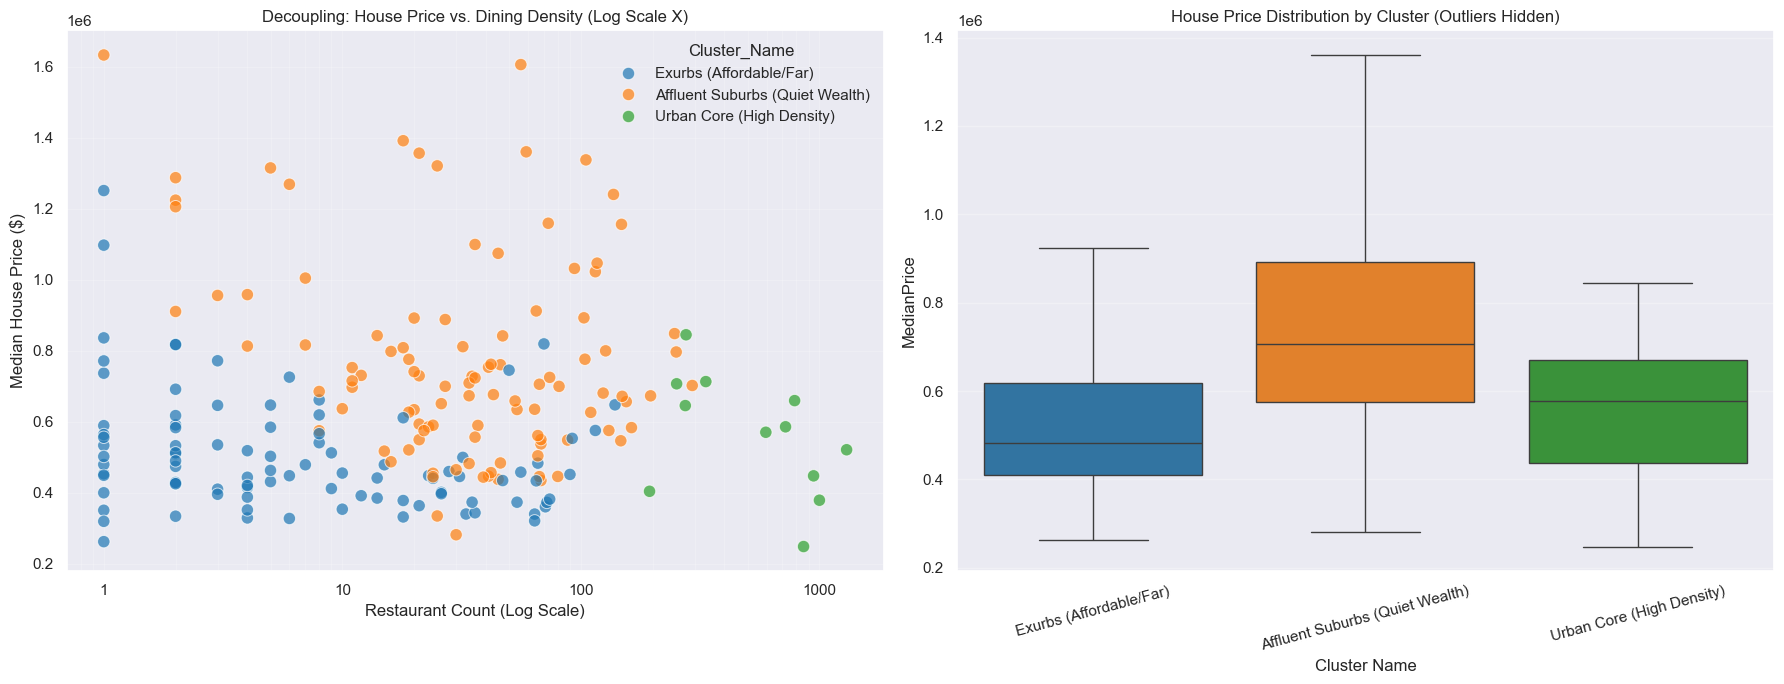


--- Part 2: Distance vs Dining Variety ---
Correlation with Distance to DC:
share_thai       -0.338677
share_japanese   -0.407463
share_american   -0.284951
share_fastfood   -0.391296
Name: DistanceToDC_Miles, dtype: float64


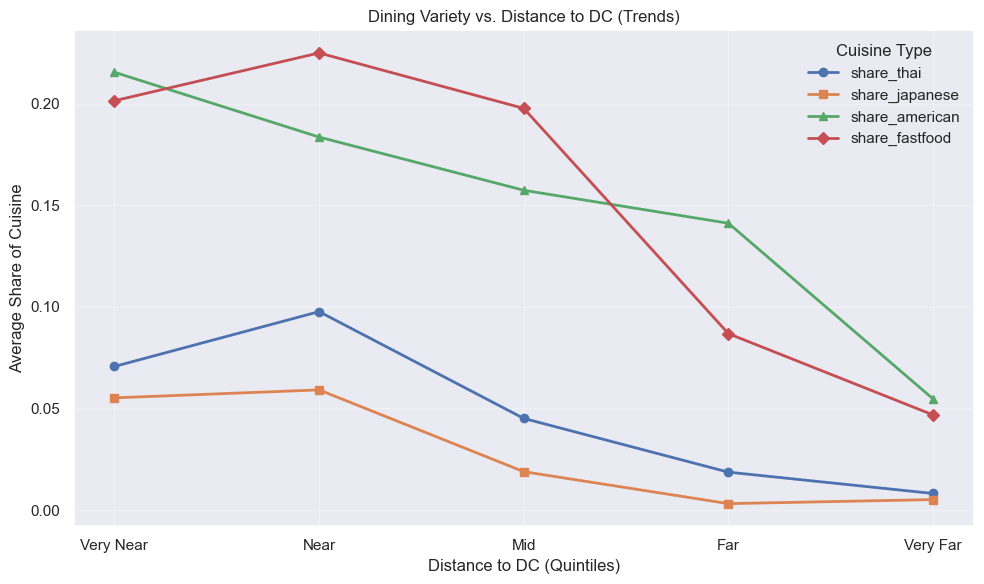


--- Part 3: Interactive Map Visualization ---
Map saved to dmv_lifestyle_clusters_map.html. Open this file in a browser to view the interactive map.
Map saved to dmv_lifestyle_clusters_map.html. Open this file in a browser to view the interactive map.


In [154]:
# Analysis: GMM Clustering - Price/Density Decoupling & Distance/Variety
# This cell performs the specific analysis requested:
# 1. Decoupling of Price vs Dining Density (Urban Core vs Affluent Suburbs)
# 2. Distance vs Dining Variety (Exotic vs Functional/Chain)
# 3. Auto-generated narratives for GMM clusters
# 4. Naming Clusters (Affluent Suburbs, Urban Core, etc.)
# 5. Map Visualization (Folium)

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import folium
from folium.plugins import MarkerCluster

# Ensure we have GMM labels for the current set of zipcodes (handling any dropped rows)
# We re-fit GMM on the current 'clusters' dataframe to ensure alignment
analysis_df = clusters.copy()

# Prepare data for GMM (using same features as before)
# We assume 'feature_cols' are available from previous cells
X_analysis = analysis_df[feature_cols].fillna(analysis_df[feature_cols].median())

# Re-scale
from sklearn.preprocessing import StandardScaler
scaler_analysis = StandardScaler()
X_analysis_scaled = scaler_analysis.fit_transform(X_analysis)

# Fit GMM (using best_k from earlier)
print(f"Fitting GMM with k={best_k} on {len(analysis_df)} zipcodes...")
gmm_model = GaussianMixture(n_components=best_k, random_state=42)
analysis_df['gmm_cluster'] = gmm_model.fit_predict(X_analysis_scaled)

# --- Part 1: Price vs Dining Density Decoupling ---
print("\n--- Part 1: Price vs Dining Density ---")
# Summary table to identify "Urban Core" vs "Affluent Suburbs"
gmm_summary = analysis_df.groupby('gmm_cluster').agg({
    'MedianPrice': 'median',
    'Yelp_Restaurant_Count': 'median',
    'DistanceToDC_Miles': 'median',
    'Yelp_Avg_Rating': 'mean',
    'ZipCode': 'count'
}).round(2).sort_values('MedianPrice', ascending=False)

print("Cluster Summary (Sorted by Price):")
print(gmm_summary)

# --- Naming Clusters ---
# Logic to name clusters based on their characteristics
# We use the sorted summary to assign names dynamically
# Rank 0 (Highest Price) -> Affluent Suburbs (if far) or Elite Urban (if near)
# Rank 1 (High Density) -> Urban Core
# Rank Last -> Exurbs / Affordable
cluster_names = {}
sorted_clusters = gmm_summary.index.tolist()

# Heuristic naming based on the summary table
# Note: This logic depends on the relative values. 
# We iterate through the sorted summary (by Price Descending)
for i, cid in enumerate(sorted_clusters):
    row = gmm_summary.loc[cid]
    price_rank = i  # 0 is highest price
    
    # Check for Urban Core (High Density, Close to DC)
    if row['Yelp_Restaurant_Count'] > 200 and row['DistanceToDC_Miles'] < 5:
        cluster_names[cid] = "Urban Core (High Density)"
    # Check for Affluent Suburbs (High Price, Low Density, Farther)
    elif row['MedianPrice'] > 600000 and row['Yelp_Restaurant_Count'] < 100:
        cluster_names[cid] = "Affluent Suburbs (Quiet Wealth)"
    # Check for Commuter Hubs (Mid Price, Mid Distance)
    elif 5 < row['DistanceToDC_Miles'] < 15:
        cluster_names[cid] = "Commuter Rings (Suburban)"
    # Check for Exurbs (Far, Low Price)
    elif row['DistanceToDC_Miles'] > 20:
        cluster_names[cid] = "Exurbs (Affordable/Far)"
    else:
        cluster_names[cid] = f"Cluster {cid} (Mixed)"

# Apply names to dataframe
analysis_df['Cluster_Name'] = analysis_df['gmm_cluster'].map(cluster_names)
print("\nAssigned Cluster Names:")
print(pd.Series(cluster_names))

# Visualization - Improved for readability (Log Scale)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Scatter: Price vs Dining Density (Log Scale X to fix "squeezed" data)
# We add 1 to count to avoid log(0) issues, though rare
sns.scatterplot(data=analysis_df, x='Yelp_Restaurant_Count', y='MedianPrice', 
                hue='Cluster_Name', palette='tab10', s=80, alpha=0.7, ax=axes[0])
axes[0].set_title('Decoupling: House Price vs. Dining Density (Log Scale X)')
axes[0].set_xscale('log') 
axes[0].xaxis.set_major_formatter(ScalarFormatter()) # Show numbers like 10, 100 instead of 10^1
axes[0].set_xlabel('Restaurant Count (Log Scale)')
axes[0].set_ylabel('Median House Price ($)')
axes[0].grid(True, which="both", ls="-", alpha=0.2)

# Boxplot: Price by Cluster (Hide outliers to focus on main distribution)
sns.boxplot(data=analysis_df, x='Cluster_Name', y='MedianPrice', palette='tab10', showfliers=False, ax=axes[1])
axes[1].set_title('House Price Distribution by Cluster (Outliers Hidden)')
axes[1].set_xlabel('Cluster Name')
axes[1].tick_params(axis='x', rotation=15) # Rotate labels for readability
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --- Part 2: Distance vs Dining Variety ---
print("\n--- Part 2: Distance vs Dining Variety ---")
# Focus on specific cuisines: Thai/Japanese (Exotic) vs American/FastFood (Functional)
variety_cols = ['share_thai', 'share_japanese', 'share_american', 'share_fastfood']

# Check correlations
corrs = analysis_df[['DistanceToDC_Miles'] + variety_cols].corr()['DistanceToDC_Miles'].drop('DistanceToDC_Miles')
print("Correlation with Distance to DC:")
print(corrs)

# Create Distance Buckets for clearer trend visualization
# We use qcut to divide into 5 equal-sized buckets (quintiles)
analysis_df['Dist_Bucket'] = pd.qcut(analysis_df['DistanceToDC_Miles'], q=5, labels=['Very Near', 'Near', 'Mid', 'Far', 'Very Far'])

# Calculate mean share per bucket
dist_variety = analysis_df.groupby('Dist_Bucket', observed=False)[variety_cols].mean()

# Plot trends
plt.figure(figsize=(10, 6))
# Plot lines for each cuisine type
markers = ['o', 's', '^', 'D']
for i, col in enumerate(variety_cols):
    plt.plot(dist_variety.index, dist_variety[col], marker=markers[i], label=col, linewidth=2)

plt.title('Dining Variety vs. Distance to DC (Trends)')
plt.xlabel('Distance to DC (Quintiles)')
plt.ylabel('Average Share of Cuisine')
plt.legend(title='Cuisine Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Part 3: Map Visualization (Folium) ---
print("\n--- Part 3: Interactive Map Visualization ---")
# Create a base map centered on DC
m = folium.Map(location=[38.9072, -77.0369], zoom_start=10, tiles='CartoDB positron')

# Define colors for clusters - using tab10 palette to match the scatter plot
import matplotlib.colors as mcolors
tab10_colors = plt.cm.tab10.colors  # Get tab10 color palette
# Match the order from seaborn's hue assignment (categorical order as they appear)
unique_clusters = analysis_df['Cluster_Name'].astype('category').cat.categories.tolist()
# Manually set colors to match scatter plot: Blue for Exurbs, Orange for Affluent Suburbs, Green for Urban Core
cluster_color_map = {
    'Exurbs (Affordable/Far)': mcolors.rgb2hex(tab10_colors[0]),  # Blue
    'Affluent Suburbs (Quiet Wealth)': mcolors.rgb2hex(tab10_colors[1]),  # Orange
    'Urban Core (High Density)': mcolors.rgb2hex(tab10_colors[2])  # Green
}
# Use the predefined mapping, fallback to tab10 for any other clusters
cluster_colors = {name: cluster_color_map.get(name, mcolors.rgb2hex(tab10_colors[i % len(tab10_colors)])) 
                  for i, name in enumerate(unique_clusters)}

# Add points to map
for idx, row in analysis_df.iterrows():
    # Skip if lat/lon is missing
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        continue
        
    cluster_name = row['Cluster_Name']
    color = cluster_colors.get(cluster_name, 'gray')
    
    popup_text = f"""
    <b>Zip: {row['ZipCode']}</b><br>
    Cluster: {cluster_name}<br>
    Price: ${row['MedianPrice']:,.0f}<br>
    Restaurants: {row['Yelp_Restaurant_Count']:.0f}<br>
    Dist to DC: {row['DistanceToDC_Miles']:.1f} mi
    """
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=folium.Popup(popup_text, max_width=300),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# Add legend (hacky way via HTML) - INCREASED SIZE (6x larger, top-right corner)
legend_html = '''
     <div style="position: fixed; 
     top: 50px; right: 50px; width: 600px; height: auto; 
     border:6px solid grey; z-index:9999; font-size:48px;
     background-color:white; opacity: 0.95; padding: 50px;">
     <b>Cluster Legend</b><br>
'''
for name, color in cluster_colors.items():
    legend_html += f'<i style="background:{color};width:48px;height:48px;display:inline-block;margin-right:30px;"></i>{name}<br>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
map_path = 'dmv_lifestyle_clusters_map.html'
m.save(map_path)
print(f"Map saved to {map_path}. Open this file in a browser to view the interactive map.")

In [155]:
# Save combined outputs: include GMM/HDBSCAN labels if available and cleaned dataset
# Note: clusters dataframe might have fewer rows than original X_scaled due to filtering small clusters
# We need to align gmm_labels/hdb_labels with the filtered clusters dataframe if filtering happened.
# However, gmm_labels was computed on the FULL X_scaled before filtering.
# Best approach: Re-run GMM/HDBSCAN on the filtered data OR just save what we have if lengths match.

# Check if clusters was filtered (length mismatch)
if len(clusters) != len(gmm_labels):
    print(f"Warning: Cluster dataframe length ({len(clusters)}) != GMM labels length ({len(gmm_labels)}).")
    print("Re-fitting GMM and HDBSCAN on filtered data for consistency...")
    
    # Re-create X_scaled from the filtered 'clusters' dataframe to ensure alignment
    # We need to reconstruct the feature matrix X from the current 'clusters' df
    # (assuming 'clusters' still has all the feature columns)
    X_filtered = clusters[feature_cols]
    X_filtered = X_filtered.fillna(X_filtered.median(numeric_only=True))
    X_scaled_filtered = scaler.fit_transform(X_filtered)
    
    # Re-fit GMM
    from sklearn.mixture import GaussianMixture
    gmm_new = GaussianMixture(n_components=best_k, random_state=42)
    gmm_labels_new = gmm_new.fit_predict(X_scaled_filtered)
    
    clusters_out = clusters.copy()
    clusters_out['gmm_label'] = gmm_labels_new
    
    # Re-fit HDBSCAN if it was available
    if hdb_labels is not None:
        try:
            if hdbscan is not None:
                hdb_new = hdbscan.HDBSCAN(min_cluster_size=8, metric='euclidean')
                hdb_labels_new = hdb_new.fit_predict(X_scaled_filtered)
                clusters_out['hdbscan_label'] = hdb_labels_new
        except Exception as e:
            print("HDBSCAN re-fit failed:", e)
else:
    # Lengths match, just assign
    clusters_out = clusters.copy()
    clusters_out['gmm_label'] = gmm_labels
    if hdb_labels is not None:
        clusters_out['hdbscan_label'] = hdb_labels

clusters_out.to_csv('DMV_Yelp_Dataset_with_clusters.csv', index=False)
print('Saved DMV_Yelp_Dataset_with_clusters.csv')
# Print brief score summary
print('Score summary:', scores)

Re-fitting GMM and HDBSCAN on filtered data for consistency...
Saved DMV_Yelp_Dataset_with_clusters.csv
Score summary: {'kmeans': {'silhouette': 0.25719925636318075, 'calinski_harabasz': 69.41605523507387}, 'gmm': {'silhouette': 0.19517694243739261, 'calinski_harabasz': 65.69073461247946}, 'hdbscan': {'silhouette': 0.4114781219375285, 'calinski_harabasz': 119.48710168635152}}
Saved DMV_Yelp_Dataset_with_clusters.csv
Score summary: {'kmeans': {'silhouette': 0.25719925636318075, 'calinski_harabasz': 69.41605523507387}, 'gmm': {'silhouette': 0.19517694243739261, 'calinski_harabasz': 65.69073461247946}, 'hdbscan': {'silhouette': 0.4114781219375285, 'calinski_harabasz': 119.48710168635152}}
